In [2]:
import numpy as np
import os

import poppy
import dms # modified gpipsfs DM module (https://github.com/geminiplanetimager/gpipsfs/blob/master/gpipsfs/dms.py)
import pdb

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

matplotlib.rcParams['font.size'] = 9

import astropy.io
import astropy.units as u

import scipy.interpolate
import scipy.signal
import scipy.optimize

#print("Imported Poppy module ({0}) from {1:s}".format(poppy.__version__, os.path.abspath(poppy.__file__)))
print("Poppy version {0}".format(poppy.__version__))

Poppy version 0.6.2.dev1122


In [2]:
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/WFIRST_tech/webbpsf-data-source')

## WFIRST SPC with single pupil-conjugate DM (without WebbPSF)

In [3]:
ovsamp=3
fov_arcsec = 2*0.82
pixscale = fov_arcsec/76
wavelen = 770e-9

Tel_fname = os.path.join(os.environ['WEBBPSF_PATH'], "AFTA_CGI_C5_Pupil_onax_256px.fits")
SP_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/CHARSPC_SP_256pix.fits.gz")
FPM_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/CHARSPC_FPM_25WA90_2x65deg_-_FP1res4_evensamp_D072_F770.fits.gz")
LS_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/optics/SPC_LS_30D88_256pix.fits.gz")
#primary_OPD_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/CGI_static_test_OPD_D256.fits")
primary_OPD_fname = "CGI_static_test_OPD_D256.fits"
primary_OPD = astropy.io.fits.getdata(primary_OPD_fname)

#Nact = 52
Nact = 26
X = np.ones((Nact,1)) * np.arange(Nact)
kx = 5.
A = 0.5
#DMinf_fname = os.path.join(os.environ['WEBBPSF_PATH'], "CGI/OPD/DM_influence_Nact{:d}_D256.fits".format(Nact))
DMinf_fname = "DM_influence_Nact{:d}_D256.fits".format(Nact)

splc_1dm_optsys = poppy.OpticalSystem(oversample=ovsamp)

splc_1dm_optsys.add_pupil(transmission=Tel_fname, opd=primary_OPD_fname)
#splc_1dm_optsys.add_pupil(transmission=Tel_fname)

actuator_spacing = splc_1dm_optsys.planes[0].pupil_diam.value/(Nact-1) # telescope pupil-projected spacing in meters
sinx_surface = A*np.sin(2*np.pi*kx/Nact*X)
flat_com = np.zeros((Nact,Nact))

cgi_DM1 = dms.DeformableMirror(shape=(Nact,Nact), influence_func=DMinf_fname,
                               actuator_spacing=actuator_spacing, name='DM1')
splc_1dm_optsys.add_pupil(optic=cgi_DM1, name='DM1')

splc_1dm_optsys.add_pupil(transmission=SP_fname, name='SP', shift=None)
splc_1dm_optsys.add_image(transmission=FPM_fname, name='FPM')
splc_1dm_optsys.add_pupil(transmission=LS_fname, name='LS')
splc_1dm_optsys.add_detector(0.1, fov_arcsec=fov_arcsec)

occ_box_size = 1
splc_1dm_optsys = poppy.MatrixFTCoronagraph(splc_1dm_optsys, oversample=ovsamp, occulter_box=occ_box_size)

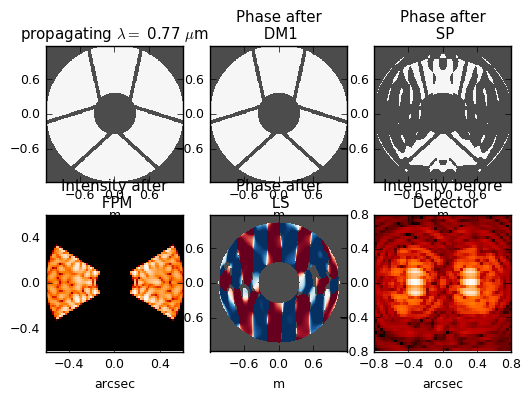

In [4]:
cgi_DM1.set_surface(sinx_surface, units='nm')
splc_1dm_sinx_psf, splc_1dm_interm_wfs = splc_1dm_optsys.calc_psf(wavelen, display_intermediates=True,
                                                                  return_intermediates=True)

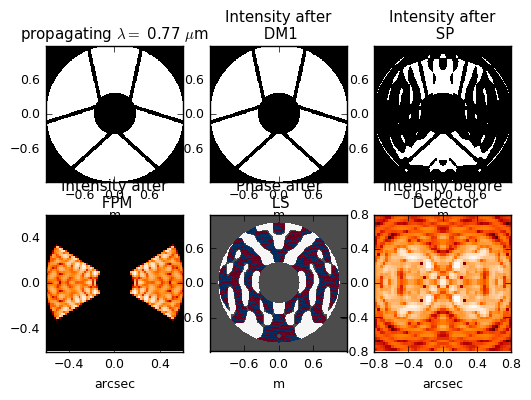

In [5]:
cgi_DM1.set_surface(flat_com, units='nm')
splc_1dm_optsys.planes[0].opd = primary_OPD*0
_, splc_1dm_flat_unab_wfs = splc_1dm_optsys.calc_psf(wavelen, display_intermediates=True,
                                                     return_intermediates=True)

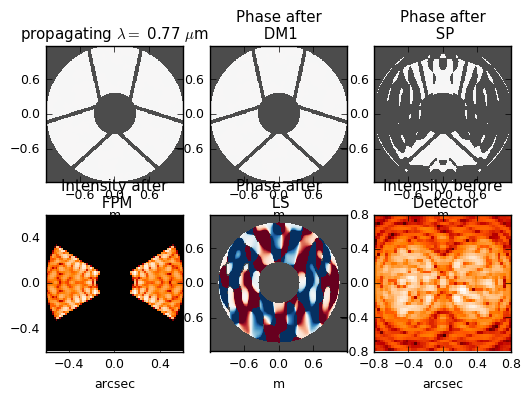

In [6]:
cgi_DM1.set_surface(flat_com, units='nm')
splc_1dm_optsys.planes[0].opd = primary_OPD
_, splc_1dm_flat_ab_wfs = splc_1dm_optsys.calc_psf(wavelen, display_intermediates=True,
                                                   return_intermediates=True)

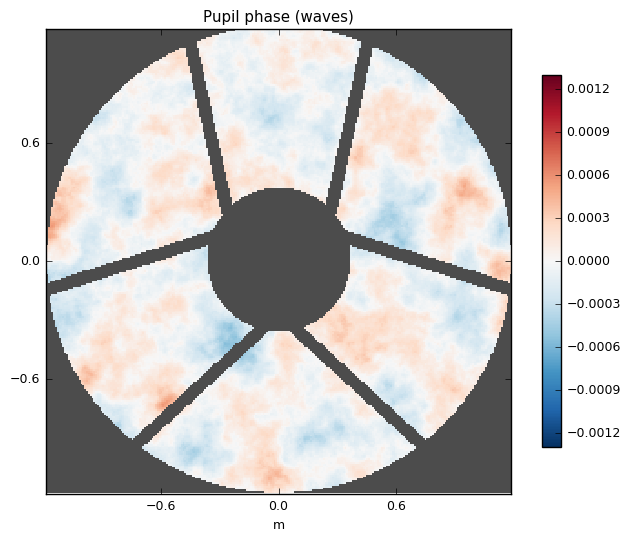

In [7]:
plt.figure(figsize=(8,6))
poppy.Wavefront.display(splc_1dm_flat_ab_wfs[0], what='phase', colorbar=True,
                        vmin=-2*A*1e-9/wavelen, vmax=2*A*1e-9/wavelen, title='Pupil phase (waves)')

## Set up for DM control

In [8]:
lamoD_asec = float(wavelen/splc_1dm_optsys.planes[0].pupil_diam.value * 180/np.pi * 3600)
print("System diffraction resolution element scale (lambda_0/D) in arcsec: {:.3f}".format(lamoD_asec))

System diffraction resolution element scale (lambda_0/D) in arcsec: 0.067


In [9]:
E_img_0 = np.copy(splc_1dm_flat_unab_wfs[-1].wavefront)
E_img_ab = np.copy(splc_1dm_flat_ab_wfs[-1].wavefront)

In [10]:
Y, X = splc_1dm_flat_unab_wfs[-1].coordinates()
Y_lamoD = Y/lamoD_asec
X_lamoD = X/lamoD_asec

### Define and test the dark zone mask

In [11]:
Rsqrd = X_lamoD**2 + Y_lamoD**2
Theta = np.rad2deg(np.arctan2(Y_lamoD,X_lamoD))

bowtie_R1 = 2.5
bowtie_R2 = 9.
bowtie_ang = 65.

dzmask_RHS = (Rsqrd >= bowtie_R1**2) & (Rsqrd <= bowtie_R2**2) & \
             (Theta >= -bowtie_ang/2) & (Theta <= bowtie_ang/2)
dzmask = dzmask_RHS | dzmask_RHS[:,::-1]
dzmask_nan = np.where(dzmask, 1, np.nan)

dz_ind_flat = np.flatnonzero(dzmask)

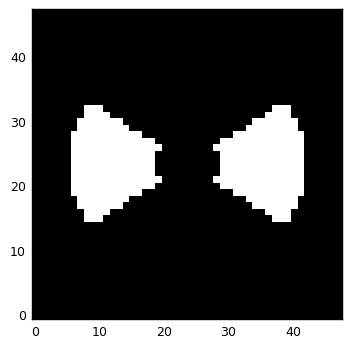

In [12]:
plt.imshow(dzmask, cmap='gray')

### Vectorize the dark zone field, with and without aberration, and test 2-D reconstruction

In [13]:
E_dz_0_col = np.matrix(E_img_0.ravel()[dz_ind_flat]).T
E_img_0_flat = np.zeros((E_img_0.size,1), dtype='complex')
E_img_0_flat[dz_ind_flat] = E_dz_0_col

E_dz_ab_col = np.matrix(E_img_ab.ravel()[dz_ind_flat]).T
E_img_ab_flat = np.zeros((E_img_ab.size,1), dtype='complex')
E_img_ab_flat[dz_ind_flat] = E_dz_ab_col

E_img_0.dtype

dtype('complex128')

In [14]:
E_img_0_2d = E_img_0_flat.reshape(E_img_0.shape)
E_img_ab_2d = E_img_ab_flat.reshape(E_img_ab.shape)
#plt.imshow(np.log10(np.power(np.abs(E_img_0_2d),2)), cmap='viridis', vmin=-12, vmax=-9)
#plt.imshow(np.log10(np.power(np.abs(E_img_ab_2d),2)), cmap='viridis', vmin=-12, vmax=-9)
#plt.colorbar()

## Compute the control effect matrix ("G")

In [15]:
G1star_fname = "G1star_splc_1dm_Nact{:d}.npy".format(Nact)
overwrite = False

In [16]:
Nact = cgi_DM1.shape[0]

In [17]:
splc_1dm_optsys.planes[0].opd = primary_OPD*0
if not os.path.exists(G1star_fname) or overwrite:
    G1star = np.zeros((Nact*Nact, dz_ind_flat.shape[0]), dtype='complex')
    for ai in range(Nact*Nact):
        probe_com = flat_com.copy().ravel()
        probe_com[ai] = 1.
        cgi_DM1.set_surface(probe_com.reshape(cgi_DM1.shape), units='nm')
        _, interm_wfs = splc_1dm_optsys.calcPSF(wavelen, display_intermediates=False,
                                                return_intermediates=True)
        E_img = np.copy(interm_wfs[-1].wavefront)
        G1star[ai, :] = np.conj(E_img.ravel()[dz_ind_flat])
    np.save(G1star_fname, G1star)
else:
    G1star = np.load(G1star_fname)

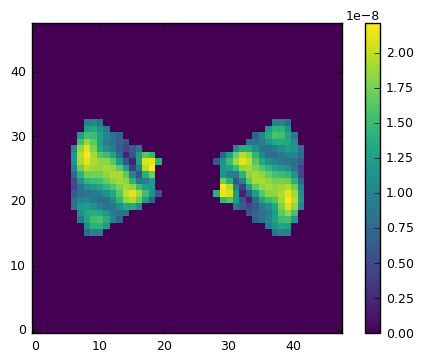

In [18]:
### inspect G1star
test_act_idx = 300
E_dz_flat = np.conj(G1star[test_act_idx, :])
E_img_flat = np.zeros(E_img_0.size, dtype='complex')
E_img_flat[dz_ind_flat] = E_dz_flat
E_img_2d = E_img_flat.reshape(E_img_0.shape)
E_diff_img_2d = E_img_2d - E_img_0_2d
#plt.imshow(np.log10(np.power(np.abs(E_img_2d),2)), cmap='viridis')
plt.imshow(np.absolute(E_diff_img_2d), cmap='viridis')
#plt.imshow(np.absolute(E_img_2d), cmap='viridis')
plt.colorbar()

In [19]:
G1star.shape

(676, 344)

In [20]:
G1 = np.matrix(G1star).H
G1.shape

(344, 676)

In [21]:
M = np.real(G1.H*G1)
M.shape

(676, 676)

In [22]:
EyeM = np.eye(M.shape[0])*np.max(np.diag(M))
EyeM.shape

(676, 676)

## Control loop

In [23]:
print("Spatial mean unaberrated dark zone intensity: {:.3e}".format(np.mean(np.power(np.absolute(E_dz_0_col),2))))
print("Spatial mean aberrated dark zone intensity: {:.3e}".format(np.mean(np.power(np.absolute(E_dz_ab_col),2))))

Spatial mean unaberrated dark zone intensity: 5.646e-11
Spatial mean aberrated dark zone intensity: 1.632e-10


In [24]:
splc_1dm_optsys.planes[0].opd = primary_OPD
cgi_DM1.set_surface(flat_com, units='nm')
realG1starEab = np.real(G1star*E_dz_ab_col)
realG1starEab.shape

(676, 1)

In [25]:
def eval_regularization(mu, optsys, wavelen, DM1, com_current, M, EyeM, realG1starEab, dz_ind_flat):
    correction = np.linalg.lstsq(-(EyeM/mu + M), realG1starEab)[0]
    DM1.set_surface(com_current + correction.reshape(DM1.shape), units='nm')
    _, wfs = optsys.calcPSF(wavelen, display_intermediates=False, return_intermediates=True)
    E_dz_flat = wfs[-1].wavefront.ravel()[dz_ind_flat]
    return np.mean(np.power(np.absolute(E_dz_flat),2))

In [26]:
mu_test = 1e3
test_eval = eval_regularization(mu_test, splc_1dm_optsys, wavelen, cgi_DM1, flat_com,
                                M, EyeM, realG1starEab, dz_ind_flat)
print(test_eval)

5.64768424981e-11


In [27]:
Nitr = 2
com = flat_com.copy()
cgi_DM1.set_surface(com, units='nm')
realG1starE = np.real(G1star*E_dz_ab_col)
mu_bounds = [1, 1e9]

print("Spatial mean aberrated dark zone intensity: {:.3e}".format(
        np.mean(np.power(np.absolute(E_dz_ab_col),2))))

for ii in range(Nitr):
    fmin_result = scipy.optimize.minimize_scalar(eval_regularization, bounds=mu_bounds, method='Bounded', 
                                                 args=(splc_1dm_optsys, wavelen, cgi_DM1, com,
                                                       M, EyeM, realG1starE, dz_ind_flat))
    mu = fmin_result['x']
    correction = np.linalg.lstsq(-(EyeM/mu + M), realG1starE)[0]
    
    com += correction.reshape(cgi_DM1.shape)
    
    cgi_DM1.set_surface(com, units='nm')
    _, wfs = splc_1dm_optsys.calcPSF(wavelen, display_intermediates=False,
                                          return_intermediates=True)
    E_img_c = np.copy(wfs[-1].wavefront)
    E_dz_c_col = np.matrix(E_img_c.ravel()[dz_ind_flat]).T
    print("iter #{:d}: mu = {:.3e}, spatial mean dark zone intensity = {:.3e}".format(
           ii+1, mu, np.mean(np.power(np.absolute(E_dz_c_col),2))))
    realG1starE = np.real(G1star*E_dz_c_col)

Spatial mean aberrated dark zone intensity: 1.632e-10
iter #1: mu = 9.998e+08, spatial mean dark zone intensity = 5.640e-11
iter #2: mu = 3.681e+05, spatial mean dark zone intensity = 5.640e-11


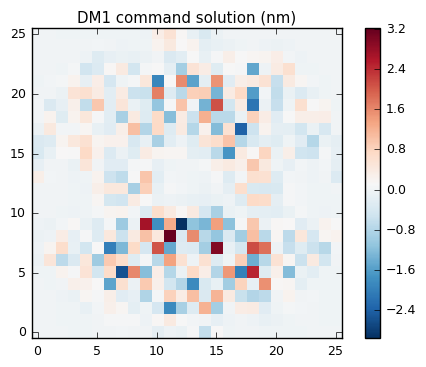

In [28]:
plt.imshow(com, cmap='RdBu_r')
plt.colorbar()
plt.title('DM1 command solution (nm)')

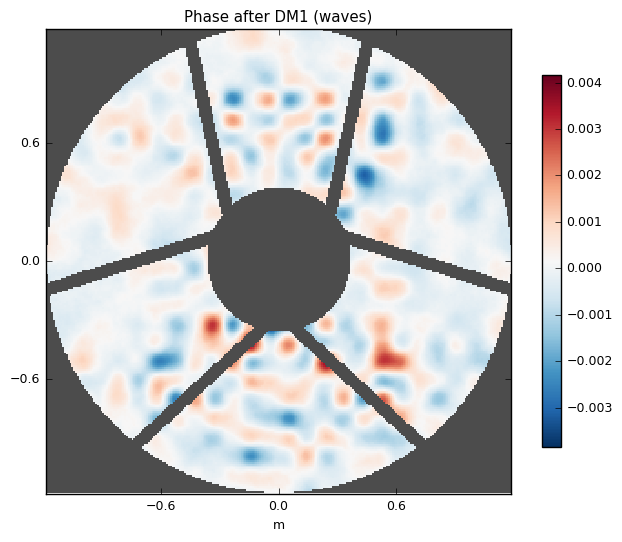

In [29]:
plt.figure(figsize=(8,6))

poppy.Wavefront.display(wfs[1], what='phase', colorbar=True,
                        vmin=np.min(com)*1e-9/wavelen, vmax=np.max(com)*1e-9/wavelen,
                        title='Phase after DM1 (waves)')

/Users/nzimmerm/anaconda3/envs/wfirst-dev/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/nzimmerm/anaconda3/envs/wfirst-dev/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


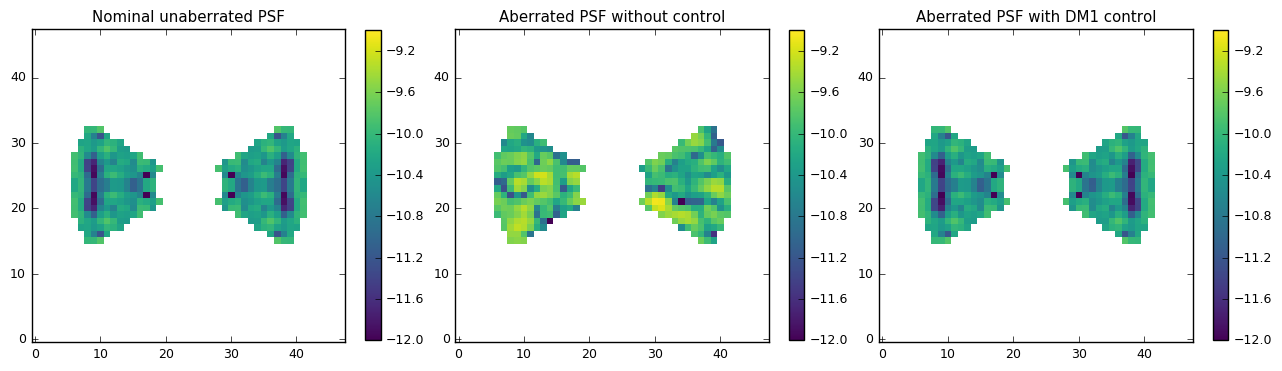

In [30]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.08)

plt.subplot(131)
plt.imshow(np.log10(np.power(np.abs(E_img_0_2d),2)), cmap='viridis', vmin=-12, vmax=-9)
plt.colorbar(shrink=0.8)
plt.title('Nominal unaberrated PSF')

plt.subplot(132)
plt.imshow(np.log10(np.power(np.abs(E_img_ab_2d),2)), cmap='viridis', vmin=-12, vmax=-9)
plt.colorbar(shrink=0.8)
plt.title('Aberrated PSF without control')

plt.subplot(133)
plt.imshow(np.log10(np.power(np.abs(E_img_c),2))*dzmask_nan, cmap='viridis', vmin=-12, vmax=-9)
plt.colorbar(shrink=0.8)
plt.title('Aberrated PSF with DM1 control')